In [1]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs
!git lfs install
!git clone https://github.com/shahanHasan/Spam-Email-Classification-Adversarial-Attacks.git

Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 90 not upgraded.
Need to get 6,229 kB of archives.
After this operation, 14.5 MB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu bionic/main amd64 git-lfs amd64 2.13.3 [6,229 kB]
Fetched 6,229 kB in 1s (6,925 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/pe

In [2]:
%cd Spam-Email-Classification-Adversarial-Attacks/
# !git lfs pull
!ls

/content/Spam-Email-Classification-Adversarial-Attacks
 alg_1.png
 alg_2.png
 alg_3.png
 Augmented_emails.csv
 comparison
'Comparison of Models | Adversarial Attacks data Preparation.ipynb'
 EDA
 emails.csv
 heatmaps
 Methodology
 Methodology.jpg
 README.md
'SPAM Email Classification .ipynb'
 Spam_Email_Classification_with_ANN,_RNN,_CNN_and_CNN_with_word_embeddings.ipynb
 Spam_Email_Classification_with_ANN,_RNN,_CNN_with_pretrained_glove_Word_embeddings_.ipynb
 utils.py
 Visuals


In [3]:
import numpy as np
import pandas as pd
import wordcloud
import seaborn as sns
import matplotlib.pyplot as plt


from keras import backend as K

from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from keras.models import Sequential
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding,concatenate, Bidirectional
from keras.layers import Dropout, Input, LeakyReLU, Conv1D, GlobalMaxPooling1D,InputLayer, ReLU, LSTM


#Utils
from keras.utils.vis_utils import plot_model
from IPython.display import SVG
from keras.utils import vis_utils
from sklearn.manifold import TSNE

#!pip3 install keras_metrics
import tensorflow as tf
from tensorflow.python.keras.metrics import Metric
from tensorflow.keras.optimizers import Adam

import io
from google.colab import files


In [4]:
from google.colab import drive
# drive.mount('/content/drive')

In [5]:
#metrics
from sklearn.metrics import f1_score , recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#Classifiers 
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Time and counters
from time import perf_counter

#grid search of params
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

# NLP lib
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk import flatten , PorterStemmer, WordNetLemmatizer, FreqDist
from collections import Counter

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

#Mark Down print
from IPython.display import Markdown, display
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

# File optimization
import h5py

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [6]:
import sys
# sys.path.append('drive/MyDrive/SPAM classification deep learning/')
from utils import *
"""
printmd, get_confusion_matrix_heatmap, ROC_AUC, Word_Embeddings_visualise_TSNE, 
read_glove_vecs, X_to_index, sentences_to_indices, get_Metrics, 
pretrained_embedding_layer,  ANN_with_glove, RNN_with_glove, CNN_with_glove
ANN_with_glove_architecture_2
""" 


'\nprintmd, get_confusion_matrix_heatmap, ROC_AUC, Word_Embeddings_visualise_TSNE, \nread_glove_vecs, X_to_index, sentences_to_indices, get_Metrics, \npretrained_embedding_layer,  ANN_with_glove, RNN_with_glove, CNN_with_glove\nANN_with_glove_architecture_2\n'

# Data set Cleaning

In [7]:
#Test Train Split of Data
# load data

# data = pd.read_csv('drive/MyDrive/SPAM classification deep learning/Dataset/Augmented_emails.csv')
data = pd.read_csv('Augmented_emails.csv')
#Label
data['spam'] = [1 if x == 1.0 else 0 for x in data['spam']]

#remove duplicated data
print(f"duplicated entries {data.duplicated().sum()}\n")
data = data.drop_duplicates()
print(f"duplicated entries {data.duplicated().sum()}\n")

#remove Null values
print("Number of null features in the dataset :")
print(f"{data.isnull().sum()}\n")

data.dropna(subset=["spam"], inplace=True)

print("Number of null features in the dataset :")
print(f"{data.isnull().sum()}")
print()

print(f"shape of the dataset : {data.shape}, Number of rows and columns : {data.shape[0]} , {data.shape[1]}\n")

# Convert data to H5py file 
data.to_hdf('data.h5', 'data', mode='w',format='table',data_columns=True)

data = pd.read_hdf('data.h5', 'data')
data = pd.DataFrame(data)
#Make a copy of the data set.
data_ANN_RNN_CNN = data.copy()

data.head(10)

duplicated entries 0

duplicated entries 0

Number of null features in the dataset :
Unnamed: 0    0
X             2
spam          0
dtype: int64

Number of null features in the dataset :
Unnamed: 0    0
X             2
spam          0
dtype: int64

shape of the dataset : (5495, 3), Number of rows and columns : 5495 , 3



,Unnamed: 0,X,spam
0,0,naturally irresistible corporate identity real...,1
1,1,stock trading gunslinger fanny merrill muzo co...,1
2,2,unbelievable home made easy wanting show homeo...,1
3,3,color printing special request additional info...,1
4,4,money software software compatibility great gr...,1
5,5,great nnews hello welcome medzonline groundsel...,1
6,6,play motion homeland security investment terro...,1
7,7,save money getting thing tried cialls even ima...,1
8,8,undeliverable home based business grownup mess...,1
9,9,save money getting thing tried cialls even ima...,1


# **Loading pretrained word embeddings (GLOVE)** 

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!ls
!pwd
"""
Data Preprocessing to be used with glove

Tasks : Convert input data/Train data to glove word index
"""
from nltk.tokenize import word_tokenize
# word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('drive/MyDrive/SPAM classification deep learning/Glove/glove.6B.100d.txt')
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('../drive/MyDrive/Glove/glove.6B.100d.txt')
max_length = 2400
Embed_size = 100

print(len(word_to_index))
print(len(index_to_word))

 alg_1.png
 alg_2.png
 alg_3.png
 Augmented_emails.csv
 comparison
'Comparison of Models | Adversarial Attacks data Preparation.ipynb'
 data.h5
 EDA
 emails.csv
 heatmaps
 Methodology
 Methodology.jpg
 __pycache__
 README.md
'SPAM Email Classification .ipynb'
 Spam_Email_Classification_with_ANN,_RNN,_CNN_and_CNN_with_word_embeddings.ipynb
 Spam_Email_Classification_with_ANN,_RNN,_CNN_with_pretrained_glove_Word_embeddings_.ipynb
 utils.py
 Visuals
/content/Spam-Email-Classification-Adversarial-Attacks
400001
400001


# **Data set Pre-processing**

In [10]:
data_ANN_RNN_CNN = data_ANN_RNN_CNN.filter(['X','spam'], axis=1)
data_ANN_RNN_CNN_index = data_ANN_RNN_CNN["X"].copy()
data_ANN_RNN_CNN_index = data_ANN_RNN_CNN_index.astype(str)
# data_ANN_RNN_CNN_index = data_ANN_RNN_CNN_index.apply(lambda x: X_to_index(x, word_to_index, max_length))
X = sentences_to_indices(data_ANN_RNN_CNN_index, word_to_index, max_length)


#Label
Y = data_ANN_RNN_CNN['spam'].copy()
Y = [1 if x == 1.0 else 0.0 for x in Y]
Y = np.asarray(Y).astype('float32') 

# X.shape
print(X.shape)
print(type(X))

(5495, 2400)
<class 'numpy.ndarray'>


In [11]:
print(type(X))

<class 'numpy.ndarray'>


In [12]:
print(X.dtype)
X = X.astype("int32")
print(X.dtype)

float64
int32


In [13]:
for i in range(10):
  txt = data_ANN_RNN_CNN["X"][i]
  idx = X[i]
  print(f"{i}th training sample text : \n{txt}\n")
  print(f"{i}th training sample indexed : \n{idx}\n")

0th training sample text : 
naturally irresistible corporate identity really hard recollect company market full suqgestions information isoverwhelminq good catchy logo stylish statlonery outstanding website make task much easier promise havinq ordered iogo company automaticaily become world ieader isguite ciear without good product effective business organization practicable hotat nowadays market promise marketing effort become much effective list clear benefit creativeness hand made original logo specially done reflect distinctive company image convenience logo stationery provided format easy content management system letsyou change website content even structure promptness logo draft within three business day affordability marketing break make gap budget satisfaction guaranteed provide unlimited amount change extra fee surethat love result collaboration look portfolio interested

0th training sample indexed : 
[257316 192882 109423 ...      0      0      0]

1th training sample text 

# **Dataset Test Train Split (80 20 split)**

In [14]:
# type(Y)
# #Splitting the data - 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X , Y, test_size = 0.2, random_state = 99)
print(f"Training split input: {X_train.shape}")
print(f"Testing split input : {X_test.shape}")
print(f"Training split class: {y_train.shape}")
print(f"Testing split class : {y_test.shape}\n")

print("dtypes :")
print(f"Train : {X_train.dtype}")
print(f"Test : {X_test.dtype}")
print(f"Train label : {y_train.dtype}")
print(f"Test label : {y_test.dtype}\n")

print("Types :")
print(f"Train : {type(X_train.dtype)}")
print(f"Test : {type(X_test.dtype)}")
print(f"Train label : {type(y_train.dtype)}")
print(f"Test label : {type(y_test.dtype)}\n")

Training split input: (4396, 2400)
Testing split input : (1099, 2400)
Training split class: (4396,)
Testing split class : (1099,)

dtypes :
Train : int32
Test : int32
Train label : float32
Test label : float32

Types :
Train : <class 'numpy.dtype'>
Test : <class 'numpy.dtype'>
Train label : <class 'numpy.dtype'>
Test label : <class 'numpy.dtype'>



In [15]:
for i in range(3):
  print(X_train[i])

[372267 356798 107050 ...      0      0      0]
[164329 249943 379260 ...      0      0      0]
[191533 270807 118310 ...      0      0      0]


## **GPU Support**

In [16]:
"""
GPU support
"""
#' ' means CPU whereas '/device:G:0' means GPU

tf.test.gpu_device_name()

'/device:GPU:0'

In [17]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=8cf1efe273692c1acd31e0f3567c6cbee75ef1231bf48bb5b48bf85ad50a599a
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Gen RAM Free: 25.5 GB  | Proc size: 1.7 GB
GPU RAM Free: 14889MB | Used: 220MB | Util   1% | Total 15109MB


In [18]:
# kill the machine
# !kill -9 -1


In [19]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.539776012999937
GPU (s):
0.03668459199980134
GPU speedup over CPU: 41x


# **ANN with Glove**

In [20]:
"""
ANN with glove
"""
# ann_glove = ANN_with_glove((max_length,), word_to_vec_map, word_to_index)
ann_glove = ANN_with_glove_architecture_2((max_length,), word_to_vec_map, word_to_index)
ann_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2400)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2400, 100)         40000200  
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              103424    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                65600 

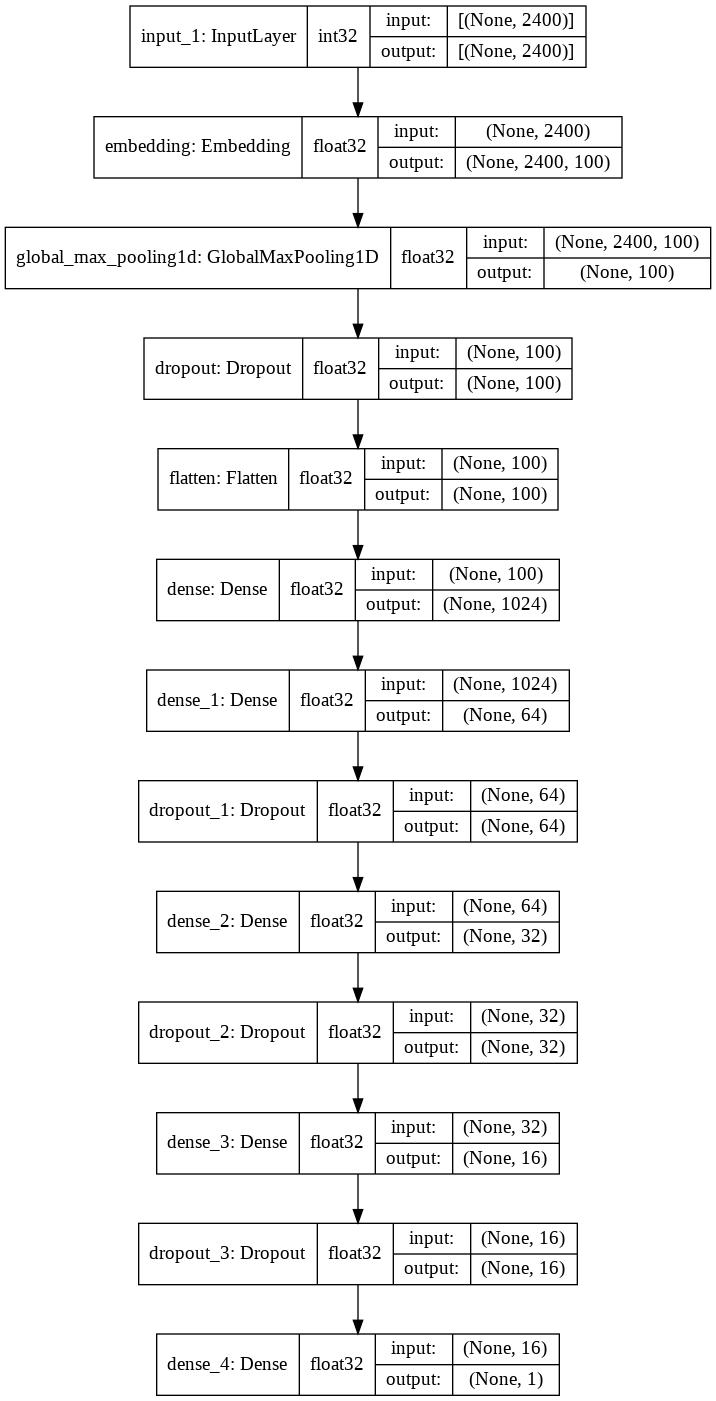

In [21]:
# display model layers
print(ann_glove.summary())
plot_model(
    ann_glove,
    # to_file="drive/MyDrive/SPAM classification deep learning/Visuals/ann_glove_1.jpeg",
    to_file="../drive/MyDrive/Glove/Visuals/ann_glove_2.jpeg",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

In [22]:
#Information about dtypes of layers of the model
[print(i.shape, i.dtype) for i in ann_glove.inputs]
print("\n\n")
[print(o.shape, o.dtype) for o in ann_glove.outputs]
print("\n\n")
[print(l.name, l.input_shape, l.dtype) for l in ann_glove.layers]

(None, 2400) <dtype: 'int32'>



(None, 1) <dtype: 'float32'>



input_1 [(None, 2400)] int32
embedding (None, 2400) float32
global_max_pooling1d (None, 2400, 100) float32
dropout (None, 100) float32
flatten (None, 100) float32
dense (None, 100) float32
dense_1 (None, 1024) float32
dropout_1 (None, 64) float32
dense_2 (None, 64) float32
dropout_2 (None, 32) float32
dense_3 (None, 32) float32
dropout_3 (None, 16) float32
dense_4 (None, 16) float32


[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [23]:
# with tf.device('/device:GPU:0'):
history = ann_glove.fit(X_train, y_train, epochs = 25, validation_steps = len(X_test), steps_per_epoch= len(X_train), validation_data=(X_test, y_test), verbose=1)

Epoch 1/25
4396/4396 [==============================] - 10s 2ms/step - loss: 0.5538 - accuracy: 0.7505 - val_loss: 0.4958 - val_accuracy: 0.7398
Epoch 2/25
4396/4396 [==============================] - 10s 2ms/step - loss: 0.4844 - accuracy: 0.7675 - val_loss: 0.4295 - val_accuracy: 0.7434
Epoch 3/25
4396/4396 [==============================] - 10s 2ms/step - loss: 0.4760 - accuracy: 0.7698 - val_loss: 0.4071 - val_accuracy: 0.7962
Epoch 4/25
4396/4396 [==============================] - 10s 2ms/step - loss: 0.4717 - accuracy: 0.7809 - val_loss: 0.4322 - val_accuracy: 0.8462
Epoch 5/25
4396/4396 [==============================] - 10s 2ms/step - loss: 0.4664 - accuracy: 0.7855 - val_loss: 0.4200 - val_accuracy: 0.7871
Epoch 6/25
4396/4396 [==============================] - 10s 2ms/step - loss: 0.4506 - accuracy: 0.7934 - val_loss: 0.3885 - val_accuracy: 0.7907
Epoch 7/25
4396/4396 [==============================] - 9s 2ms/step - loss: 0.4560 - accuracy: 0.7855 - val_loss: 0.3753 - val_acc

[[810   3]
 [153 133]]


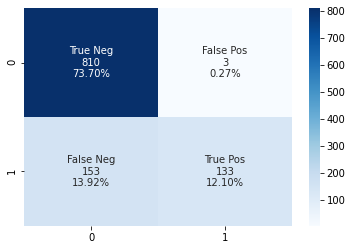

In [24]:
# Predicting the Test set results
y_pred = ann_glove.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred_ann_glove = np.array(y_pred)

#confusion matrix
get_confusion_matrix_heatmap(y_test, y_pred_ann_glove, "../drive/MyDrive/Glove/heatmaps/ANN_glove_2")

AUC: 0.730672464067298


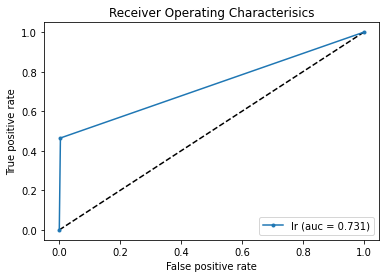

In [25]:
#AUC
lr_auc_ann_glove = ROC_AUC(y_test, y_pred_ann_glove, "../drive/MyDrive/Glove/Visuals/AUC_ANN_GLOVE_2")

35/35 [==============================] - 0s 4ms/step - loss: 0.3507 - accuracy: 0.8581
Test Loss:     35.07294058799744 %
Test Accuracy: 85.80527901649475  %
Test error: 14.194720983505249  %


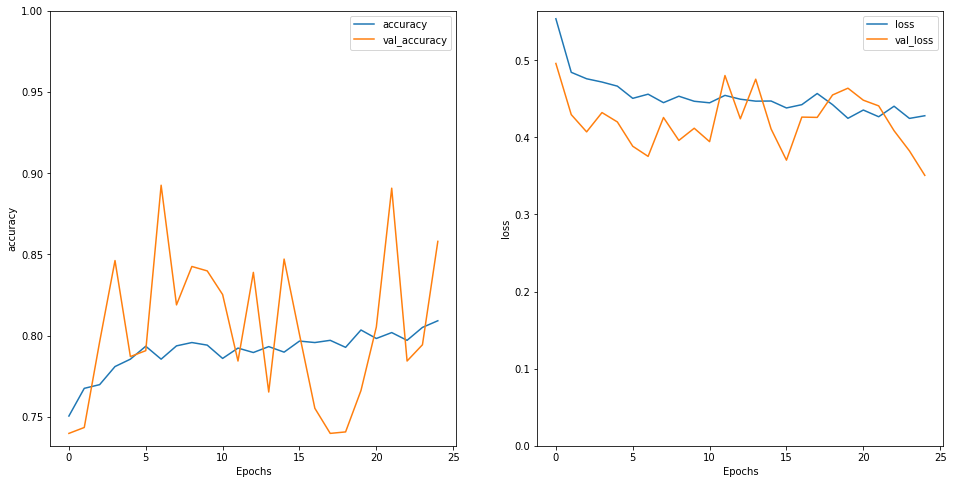

In [26]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
# plt.savefig("drive/MyDrive/SPAM classification deep learning/Visuals/ann_glove_accuracy_loss.jpeg")
plt.savefig("../drive/MyDrive/Glove/Visuals/ann_glove_accuracy_loss_2.jpeg")


test_loss_ann_glove, test_acc_ann_glove = ann_glove.evaluate(X_test, y_test)
test_err_ann_glove = 100 - test_acc_ann_glove*100

print(f"Test Loss:     {test_loss_ann_glove*100} %")
print(f"Test Accuracy: {test_acc_ann_glove*100}  %")
print(f"Test error: {test_err_ann_glove}  %")

First sample of the training data set vectorised 
[372267 356798 107050 ...      0      0      0]

First sample of the training data set using index to word : 
university texas conference energy finance february 2001 sherri thanks february vince enron north america corp jeff skilling enron 2000 sent sherri serum enron vince kaminski vince kaminski richard causey corp enron enron university texas conference energy finance february 2001 vince checking date jeff calendar assuming date february holding date whole week trip abroad think flexibility checking back touch soon resolved vince kaminski 2000 jeff skilling corp enron enron vince kaminski richard causey corp enron enron university texas conference energy finance february 2001 jeff friend university texas planning conference energy economics finance february next year would like much keynote speaker given good long term relationship would recommend speak conference talked prof ehud ronn time program think excellent forum present enro

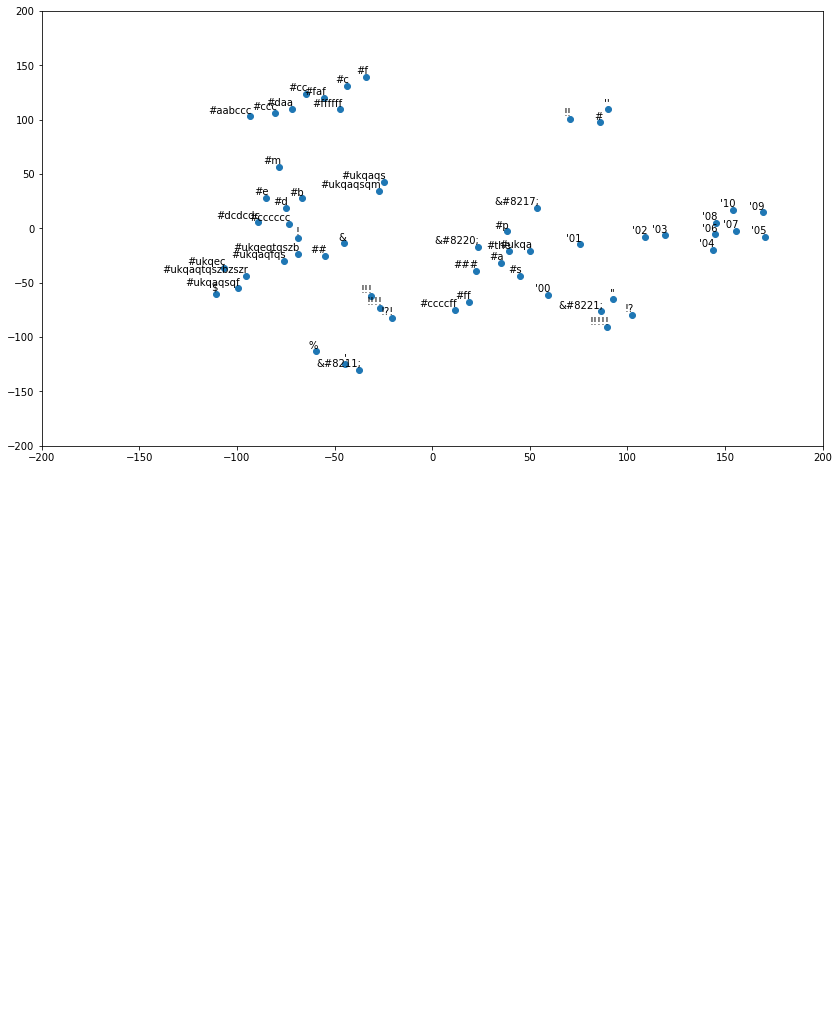

In [27]:
Word_Embeddings_visualise_TSNE(ann_glove, X_train, index_to_word, "../drive/MyDrive/Glove/Visuals/ann_glove_Embeddings_2", "embedding", -200,200,-200,200, True)

# **RNN with Glove**

In [28]:
"""
RNN with glove
"""
#rnn_glove = RNN_with_glove((max_length,), word_to_vec_map, word_to_index)
rnn_glove = RNN_with_glove_architecture_2((max_length,), word_to_vec_map, word_to_index)
rnn_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2400)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 2400, 100)         40000200  
_________________________________________________________________
bidirectional (Bidirectional (None, 2400, 256)         234496    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528 

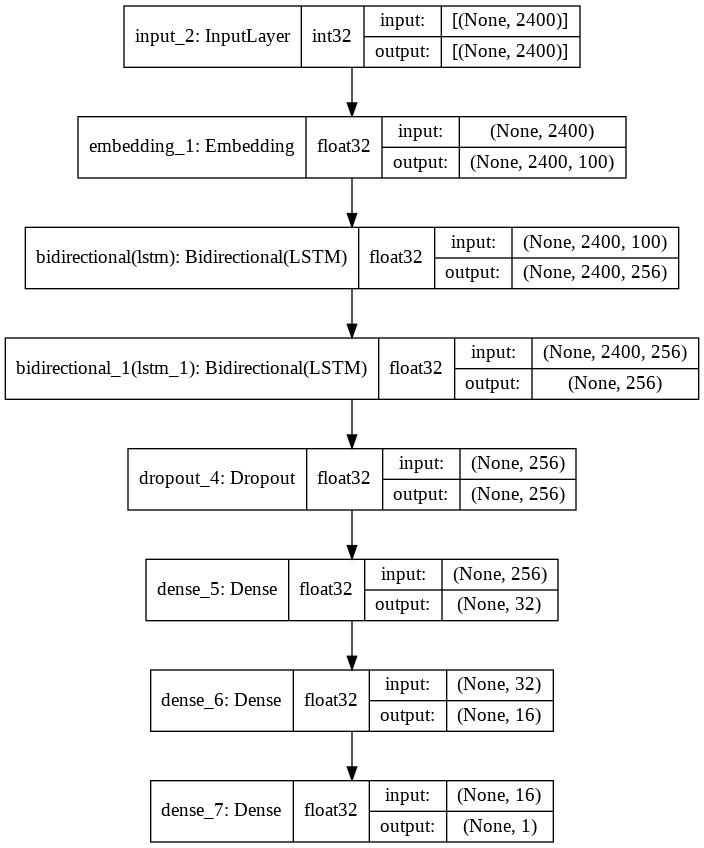

In [29]:
# display model layers
print(rnn_glove.summary())
plot_model(
    rnn_glove,
    # to_file="drive/MyDrive/SPAM classification deep learning/Visuals/rnn_glove_1.jpeg",
    to_file="../drive/MyDrive/Glove/Visuals/rnn_glove_2.jpeg",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

In [30]:
#Information about dtypes of layers of the model
[print(i.shape, i.dtype) for i in rnn_glove.inputs]
print("\n\n")
[print(o.shape, o.dtype) for o in rnn_glove.outputs]
print("\n\n")
[print(l.name, l.input_shape, l.dtype) for l in rnn_glove.layers]

(None, 2400) <dtype: 'int32'>



(None, 1) <dtype: 'float32'>



input_2 [(None, 2400)] int32
embedding_1 (None, 2400) float32
bidirectional (None, 2400, 100) float32
bidirectional_1 (None, 2400, 256) float32
dropout_4 (None, 256) float32
dense_5 (None, 256) float32
dense_6 (None, 32) float32
dense_7 (None, 16) float32


[None, None, None, None, None, None, None, None]

In [31]:
# with tf.device('/device:GPU:0'):
history = rnn_glove.fit(X_train, y_train, epochs = 4, validation_steps = len(X_test), steps_per_epoch= len(X_train), validation_data=(X_test, y_test), verbose=1)

Epoch 1/4
4396/4396 [==============================] - 1847s 419ms/step - loss: 0.2677 - accuracy: 0.8890 - val_loss: 0.1124 - val_accuracy: 0.9636
Epoch 2/4
4396/4396 [==============================] - 1850s 421ms/step - loss: 0.1163 - accuracy: 0.9570 - val_loss: 0.0934 - val_accuracy: 0.9682
Epoch 3/4
4396/4396 [==============================] - 1852s 421ms/step - loss: 0.0905 - accuracy: 0.9672 - val_loss: 0.0873 - val_accuracy: 0.9700
Epoch 4/4
4396/4396 [==============================] - 1863s 424ms/step - loss: 0.0592 - accuracy: 0.9795 - val_loss: 0.3226 - val_accuracy: 0.9227


[[812   1]
 [ 84 202]]


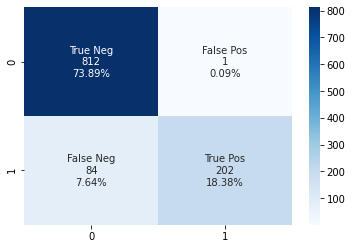

In [32]:
# Predicting the Test set results
y_pred = rnn_glove.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred_rnn_glove = np.array(y_pred)

#confusion matrix
get_confusion_matrix_heatmap(y_test, y_pred_rnn_glove, "../drive/MyDrive/Glove/heatmaps/RNN_glove_2")

AUC: 0.8525318469967916


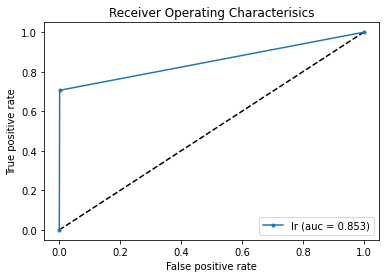

In [33]:
#AUC
lr_auc_rnn_glove = ROC_AUC(y_test, y_pred_rnn_glove, "../drive/MyDrive/Glove/Visuals/AUC_RNN_GLOVE_2")

35/35 [==============================] - 6s 157ms/step - loss: 0.3226 - accuracy: 0.9227
Test Loss:     32.2624146938324 %
Test Accuracy: 92.26569533348083  %
Test error: 7.734304666519165  %


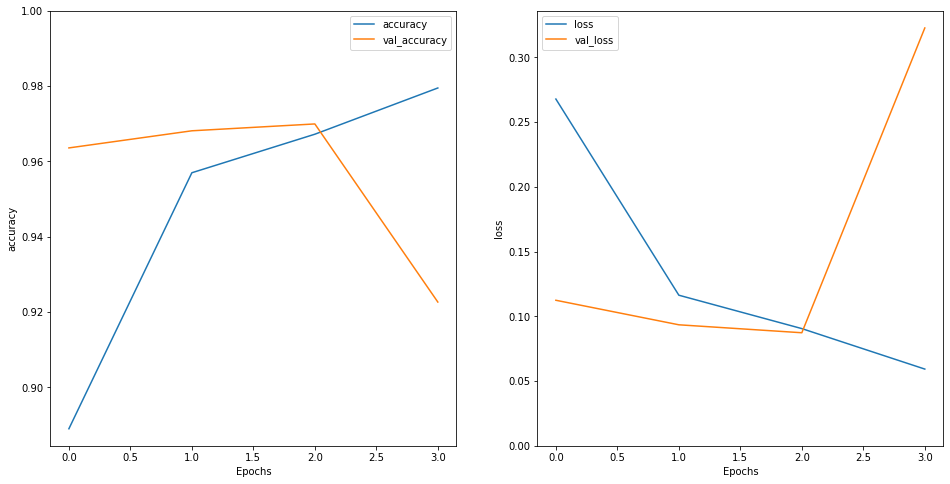

In [34]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
# plt.savefig("drive/MyDrive/SPAM classification deep learning/Visuals/rnn_glove_accuracy_loss.jpeg")
plt.savefig("../drive/MyDrive/Glove/Visuals/rnn_glove_accuracy_loss_2.jpeg")


test_loss_rnn_glove, test_acc_rnn_glove = rnn_glove.evaluate(X_test, y_test)
test_err_rnn_glove = 100 - test_acc_rnn_glove*100

print(f"Test Loss:     {test_loss_rnn_glove*100} %")
print(f"Test Accuracy: {test_acc_rnn_glove*100}  %")
print(f"Test error: {test_err_rnn_glove}  %")

In [ ]:
Word_Embeddings_visualise_TSNE(rnn_glove, X_train, index_to_word, "../drive/MyDrive/Glove/Visuals/rnn_glove_Embeddings_2", "embedding_1", -200,200,-200,200, True)

# **CNN with Glove**

In [36]:
"""
CNN with glove
"""

# cnn_glove = CNN_with_glove((max_length,), word_to_vec_map, word_to_index)
cnn_glove = CNN_with_glove_architecture_2((max_length,), word_to_vec_map, word_to_index)
cnn_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2400)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 2400, 100)         40000200  
_________________________________________________________________
conv1d (Conv1D)              (None, 2396, 100)         50100     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2392, 100)         50100     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0   

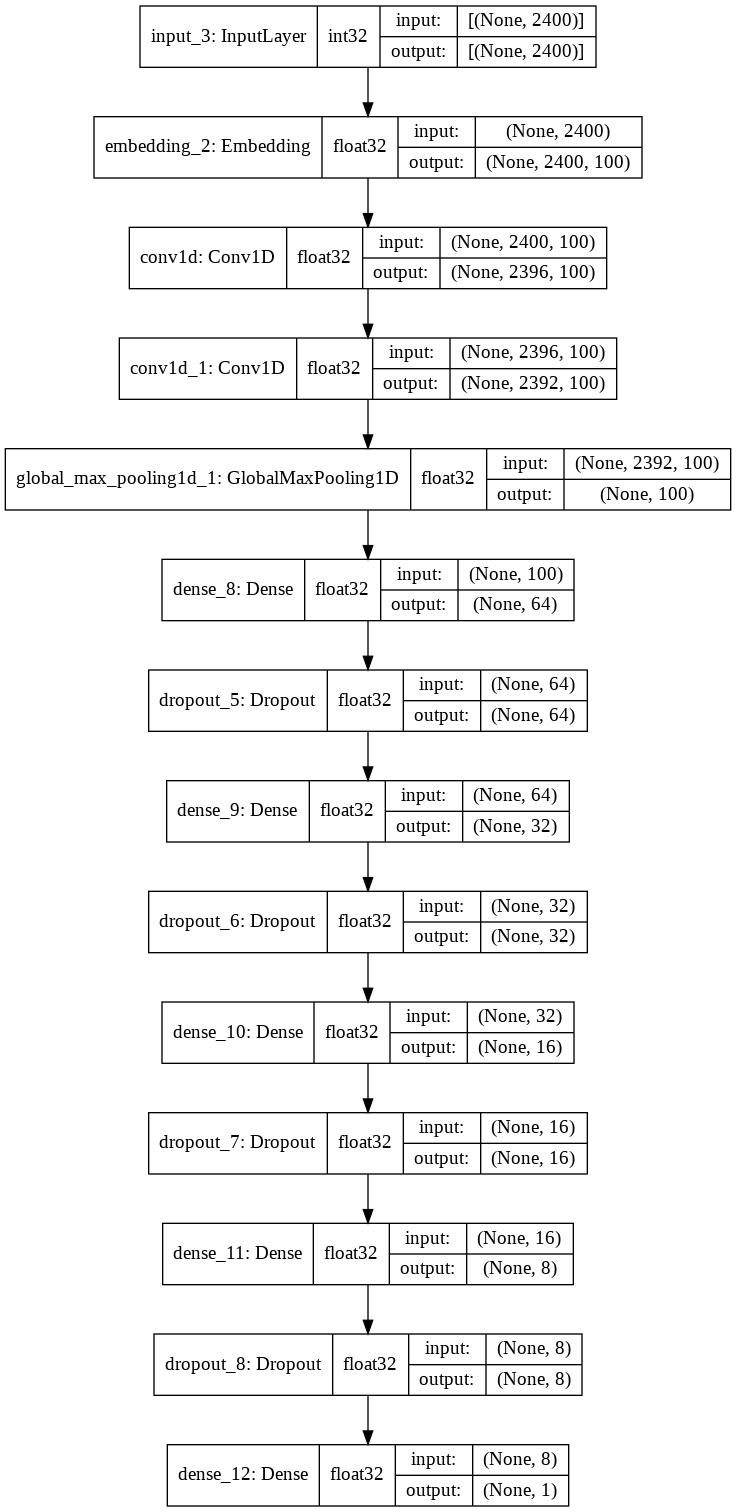

In [37]:
# display model layers
print(cnn_glove.summary())
plot_model(
    cnn_glove,
    # to_file="drive/MyDrive/SPAM classification deep learning/Visuals/cnn_glove_1.jpeg",
    to_file="../drive/MyDrive/Glove/Visuals/cnn_glove_2.jpeg",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

In [38]:
#Information about dtypes of layers of the model
[print(i.shape, i.dtype) for i in cnn_glove.inputs]
print("\n\n")
[print(o.shape, o.dtype) for o in cnn_glove.outputs]
print("\n\n")
[print(l.name, l.input_shape, l.dtype) for l in cnn_glove.layers]

(None, 2400) <dtype: 'int32'>



(None, 1) <dtype: 'float32'>



input_3 [(None, 2400)] int32
embedding_2 (None, 2400) float32
conv1d (None, 2400, 100) float32
conv1d_1 (None, 2396, 100) float32
global_max_pooling1d_1 (None, 2392, 100) float32
dense_8 (None, 100) float32
dropout_5 (None, 64) float32
dense_9 (None, 64) float32
dropout_6 (None, 32) float32
dense_10 (None, 32) float32
dropout_7 (None, 16) float32
dense_11 (None, 16) float32
dropout_8 (None, 8) float32
dense_12 (None, 8) float32


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [39]:
# with tf.device('/device:GPU:0'):
history = cnn_glove.fit(X_train, y_train, epochs = 9, validation_steps = len(X_test), steps_per_epoch= len(X_train), validation_data=(X_test, y_test), verbose=1)

Epoch 1/9
4396/4396 [==============================] - 17s 4ms/step - loss: 0.2265 - accuracy: 0.9056 - val_loss: 0.1088 - val_accuracy: 0.9572
Epoch 2/9
4396/4396 [==============================] - 16s 4ms/step - loss: 0.1051 - accuracy: 0.9666 - val_loss: 0.3069 - val_accuracy: 0.9318
Epoch 3/9
4396/4396 [==============================] - 16s 4ms/step - loss: 0.0574 - accuracy: 0.9832 - val_loss: 0.2902 - val_accuracy: 0.9572
Epoch 4/9
4396/4396 [==============================] - 16s 4ms/step - loss: 0.0530 - accuracy: 0.9841 - val_loss: 0.1233 - val_accuracy: 0.9773
Epoch 5/9
4396/4396 [==============================] - 16s 4ms/step - loss: 0.0403 - accuracy: 0.9893 - val_loss: 0.2910 - val_accuracy: 0.9509
Epoch 6/9
4396/4396 [==============================] - 16s 4ms/step - loss: 0.0352 - accuracy: 0.9914 - val_loss: 0.0919 - val_accuracy: 0.9609
Epoch 7/9
4396/4396 [==============================] - 16s 4ms/step - loss: 0.0276 - accuracy: 0.9925 - val_loss: 0.1642 - val_accuracy:

In [ ]:
# Predicting the Test set results
y_pred = cnn_glove.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred_cnn_glove = np.array(y_pred)

#confusion matrix
get_confusion_matrix_heatmap(y_test, y_pred_cnn_glove, "../drive/MyDrive/Glove/heatmaps/CNN_glove_2")

In [ ]:
#AUC
lr_auc_cnn_glove = ROC_AUC(y_test, y_pred_cnn_glove, "../drive/MyDrive/Glove/Visuals/AUC_CNN_GLOVE_2")

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
# plt.savefig("drive/MyDrive/SPAM classification deep learning/Visuals/cnn_glove_accuracy_loss.jpeg")
plt.savefig("../drive/MyDrive/Glove/Visuals/cnn_glove_accuracy_loss_2.jpeg")


test_loss_cnn_glove, test_acc_cnn_glove = cnn_glove.evaluate(X_test, y_test)
test_err_cnn_glove = 100 - test_acc_cnn_glove*100

print(f"Test Loss:     {test_loss_cnn_glove*100} %")
print(f"Test Accuracy: {test_acc_cnn_glove*100}  %")
print(f"Test error: {test_err_cnn_glove}  %")

In [ ]:
Word_Embeddings_visualise_TSNE(cnn_glove, X_train, index_to_word, "../drive/MyDrive/Glove/Visuals/cnn_glove_Embeddings_2", "embedding_2", -200,200,-200,200, True)

# **Evaluation Metrics Comparison**

In [ ]:
"""
Model comparison table with metrics : 
1. Accuracy
2. Loss
3. Error
4. Precision, Recall, F1 score
5. ROC AUC
"""

Model_comparison = {
    "Ann with GLOVE embeddings": 
    {"model":ann_glove, "acc":0, "loss" : 0, "err":0, "lr_auc":0, "f1_score":0, "precision":0, "recall":0, "y_pred":0},
    "Rnn with GLOVE embeddings": 
    {"model":rnn_glove, "acc":0, "loss" : 0, "err":0, "lr_auc":0, "f1_score":0, "precision":0, "recall":0, "y_pred":0},
    "Cnn with GLOVE embeddings": 
    {"model":cnn_glove, "acc":0, "loss" : 0, "err":0, "lr_auc":0, "f1_score":0, "precision":0, "recall":0, "y_pred":0}
}

for name, model in Model_comparison.items():

  if name == "Ann with GLOVE embeddings":
    model["y_pred"]= y_pred_ann_glove
  if name == "Rnn with GLOVE embeddings":
    model["y_pred"]=y_pred_rnn_glove
  if name == "Cnn with GLOVE embeddings":
    model["y_pred"]=y_pred_cnn_glove

for name, model in Model_comparison.items():
    y_pred = model["y_pred"]
    y_pred = np.asarray(y_pred)
    precision, recall, f1_score_, accuracy, lr_auc = get_Metrics(y_test, y_pred)
      
    if name == "Ann with GLOVE embeddings":
      model["acc"]=test_acc_ann_glove
      model["loss"]=test_loss_ann_glove
      model["err"]=test_err_ann_glove
      model["lr_auc"]=lr_auc_ann_glove
      model["f1_score"]=precision
      model["precision"]=recall
      model["recall"]=f1_score_
      
    if name == "Rnn with GLOVE embeddings":
      model["acc"]=test_acc_rnn_glove
      model["loss"]=test_loss_rnn_glove
      model["err"]=test_err_rnn_glove
      model["lr_auc"]=lr_auc_rnn_glove
      model["f1_score"]=precision
      model["precision"]=recall
      model["recall"]=f1_score_
     
    if name == "Cnn with GLOVE embeddings":
      model["acc"]=test_acc_cnn_glove
      model["loss"]=test_loss_cnn_glove
      model["err"]=test_err_cnn_glove
      model["lr_auc"]=lr_auc_cnn_glove
      model["f1_score"]=precision
      model["precision"]=recall
      model["recall"]=f1_score_
    # print(model)

models_metrics = []
for name, model in Model_comparison.items():
  #print(model["y_pred"].shape)
  precision, recall, f1_score_,  = model["precision"], model["recall"], model["f1_score"]
  accuracy, lr_auc, loss, error = model["acc"], model["lr_auc"], model["loss"], model["err"]
  # print(f"precision : {precision} recall : {recall} f1_score : {f1_score_} accuracy : {accuracy}")
  models_metrics.append([name, precision, recall, f1_score_, accuracy, error, loss, lr_auc])

df_metrics = pd.DataFrame(models_metrics)
df_metrics.columns = ['Model', 'Precision', 'Recall', 'f1 score', 'Accuracy', 'Error', 'Loss', 'ROC-AUC']
df_metrics.sort_values(by = 'Accuracy', ascending = False, inplace=True)
df_metrics.reset_index(drop = True, inplace=True)
# df_metrics.to_csv("drive/MyDrive/SPAM classification deep learning/Visuals/DNN_glove_comparison.csv")
df_metrics.to_csv("../drive/MyDrive/Glove/Visuals/DNN_glove_2_comparison.csv")
    

In [46]:
df_metrics

,Model,Precision,Recall,f1 score,Accuracy,Error,Loss,ROC-AUC
0,Cnn with GLOVE embeddings,0.971544,0.969416,0.967339,0.976342,2.365786,0.271382,0.971544
1,Rnn with GLOVE embeddings,0.852532,0.888220,0.950662,0.922657,7.734305,0.322624,0.852532
2,Ann with GLOVE embeddings,0.730672,0.771247,0.909531,0.858053,14.194721,0.350729,0.730672
